# Part 1 Library Imports & Google Drive Mount

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import time
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Part3 Data Loading and Splitting 

Source:

[1] Lab2: https://colab.research.google.com/drive/1cxfHtc4TFWSblAiyHQec3z_vnh1WEAFW?usp=sharing

In [ ]:
# Define the transform to be performed on the data [1]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('P', 'N')

# Define the path to the data on the drive [1]:
# The data is splitted manually into three folders (train, validate, test):
trainset=torchvision.datasets.ImageFolder("/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/train_small", transform=transform)
#validateset=torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/validate_p_small', transform=transform)
#testset=torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/test_p_small', transform=transform)

# Generate the loaders [1]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                               num_workers=1)
#validate_loader = torch.utils.data.DataLoader(validateset, batch_size=1,
                                               #num_workers=1)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                               #num_workers=1)

# Part5 Initalize Weight

According to the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434), "All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02." The team has some difficulty in understanding the exact math content behind this line, but find the following implementation that initilize the weights in a desired way. After research on and learning this piece of code, the team reaches to the conclusion that it is useful and reliable. Thus, the team will also use it to initialize the weights for the team's model after giving credit to it by detailed citation.

This code is directly extratced from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


In [ ]:
# custom weights initialization called on netG and netD
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Part4 Model Setup 





> Discriminator

The discriminator architecture is based on 

(1) Pytorch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434) 

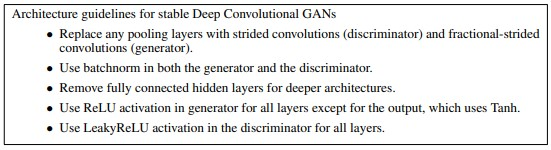

(3) Some other existing models: 
*  https://www.youtube.com/watch?v=Hp-jWm2SzR8
*  https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
*  https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
*  GAN model from APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html)  







In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label = nn.Sequential (
            #input = N x 2 x 64 x 64 
            nn.Conv2d(2,16,4,2,1),
            # 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            # output = N x 16 x 32 x 32
        )
        self.image = nn.Sequential (
            #input = N x 3 x 64 x 64 
            nn.Conv2d(3,16,4,2,1),
            # 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            # output = N x 16 x 32 x 32
        )
        self.model = nn.Sequential(
            # input = N x 32 x 32 x 32 
            # nn.Conv2d(i,o,k,s,p)
            # 32 x 32
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 4 
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 2 x 2 
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        # size of x : N x 3 x 64 x 64
        x = self.image(x)
        # size of y : N x 16 x 32 x 32

        # size of y : N x 2 x 64 x 64
        y = self.label(y)
        # size of y : N x 16 x 32 x 32

        # size of xy : N x 32 x 32 x 32
        xy = torch.cat([x,y], dim=1)

        # size of model: N x 1 x 1 x 1
        model = self.model(xy)

        # return size: N
        return model.view(model.size(0))

In [ ]:
# Print the architecture of the GAN
D = Discriminator()
D.cuda()
D.apply(initialize_weights)
print(D)

Discriminator(
  (label): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (image): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): B


> Generator 

The generator architecture is based on 

(1) Pytorch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434)

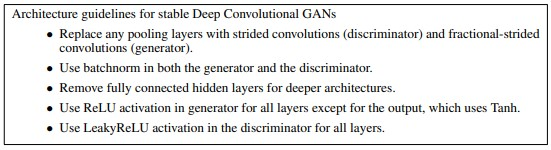

(3) Some other existing models: 
* https://www.youtube.com/watch?v=Hp-jWm2SzR8
* https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
* https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
* GAN model from APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html) 

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label = nn.Sequential(
            #input = N x 2 x 1 x 1
            nn.ConvTranspose2d(2,512,4,2,1,0),
            # 2 x 2 
            nn.BatchNorm2d(512),
            nn.ReLU()
            # output = N x 512 x 2 x 2
        )
        self.noise = nn.Sequential(
            # input = N x 100 x 1 x 1 
            nn.ConvTranspose2d(100,512,4,2,1,0),
            # 2 x 2 
            nn.BatchNorm2d(512),
            nn.ReLU()
            # output = N x 512 x 2 x 2
        )
        self.model = nn.Sequential(
            # input = N x 1024 x 2 x 2
            # nn.Conv2d(i,o,k,s,p,op)
            # 2 x 2 
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, 0),
            nn.BatchNorm2d(512, 0.1),
            nn.ReLU(),
            # 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, 0),
            nn.BatchNorm2d(256, 0.1),
            nn.ReLU(),
            # 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, 0),
            nn.BatchNorm2d(128, 0.1),
            nn.ReLU(),
            # 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, 0),
            nn.BatchNorm2d(64, 0.1),
            nn.ReLU(),
            # 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, 0),
            nn.Tanh()
            # output = N x 3 x 64 x 64
        )
    def forward(self, x, y):
      # size of x: N x 100
      x = x.view(x.size(0), 100, 1, 1)
      #print(x.shape)
      # size of x: N x 100 x 1 x 1
      x = self.noise(x)
      # size of x: N x 512 x 2 x 2


      # size of y: N x 2 x 1 x 1 
      y = self.label(y)
      #print(y.shape)
      # size of y: N x 512 x 2 x 2

      # size of xy: N x 1024 x 2 x 2 
      xy = torch.cat([x,y], dim=1)

      # return size: N x 3 x 64 x 64 
      return self.model(xy)

In [ ]:
# Print the architecture of the GAN
G = Generator()
G.cuda()
G.apply(initialize_weights)
print(G)

Generator(
  (label): Sequential(
    (0): ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (noise): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=0.1, momentum=0.1, affine=True, t

# Part5 GPU Enabling



In [ ]:
# Enable run on GPU:
use_cuda = True



# Part 7 Onehot Encoding for Smiling Labels



Source: https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb

In [ ]:
# convert labels to onehot encoding
onehot = torch.zeros(2, 2).scatter_(1, torch.tensor([0, 1]).view(2,1), 1)
# reshape labels to image size, with number of labels as channel
fill = torch.zeros([2, 2, 64, 64])
#channel corresponding to label will be set one and all other zeros
for i in range(2):
    fill[i, i, :, :] = 1
# create labels for testing generator
test_y = torch.tensor([0, 1]*2).type(torch.LongTensor)
# convert to one hot encoding
test_Gy = onehot[test_y]
if use_cuda and torch.cuda.is_available():
  test_Gy = test_Gy.cuda()

# Part7 Training

The training proceduer is based on 

(1) Pytorch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks": use BCE as loss function and use Adam optimizer with a learning rate of 0.0002 (https://arxiv.org/abs/1511.06434) 

(3) Some other existing models: 
* https://www.youtube.com/watch?v=Hp-jWm2SzR8
* https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
* https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
* GAN model training procedurefrom APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html)

In [ ]:
test_s_label =  (torch.rand(64, 1)*2).type(torch.LongTensor).squeeze()

print(test_s_label)
test_s_label = onehot[test_s_label].unsqueeze(2).unsqueeze(3)


tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])


[0/5][0/32]	Loss_D: 1.3859	Loss_G: 0.6601	D(x): 0.6922	D(G(z)): 0.0012 / 0.0683
[1/5][0/32]	Loss_D: 1.0144	Loss_G: 0.6919	D(x): 0.3192	D(G(z)): 0.0040 / 0.0024
[2/5][0/32]	Loss_D: 1.0073	Loss_G: 0.6929	D(x): 0.3138	D(G(z)): 0.0008 / 0.0005
[3/5][0/32]	Loss_D: 1.0079	Loss_G: 0.6929	D(x): 0.3141	D(G(z)): 0.0013 / 0.0005
[4/5][0/32]	Loss_D: 1.0084	Loss_G: 0.6930	D(x): 0.3139	D(G(z)): 0.0027 / 0.0003


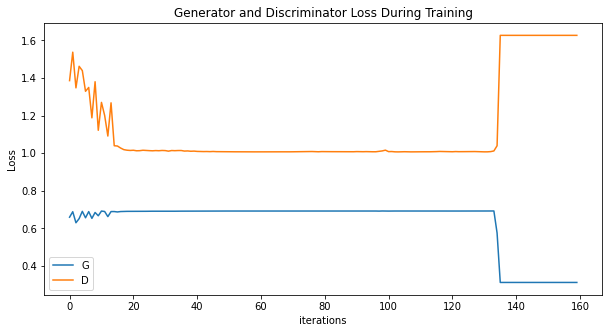

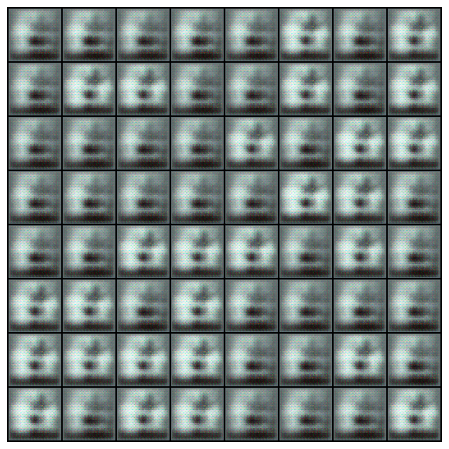

In [ ]:
lr=0.0002
num_epochs=5
batch_size = 128
    
criterion = nn.BCEWithLogitsLoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

real_label = 1.
fake_label = 0.

num_test_samples = 64
#test_noise size: 64 x 100 
test_noise = torch.randn(num_test_samples, 100)
test_s_label =  (torch.rand(num_test_samples, 1)*2).type(torch.LongTensor).squeeze()
test_s_label = onehot[test_s_label].unsqueeze(2).unsqueeze(3)
#print(test_noise.shape)
#print(test_noise)

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
  test_s_label = test_s_label.cuda()
#############################################

step = 0
img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    # s_label size: N x 2 x 64 x 64
    s_label = fill[s_label]
    # print(images.shape)
    # print(s_label.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      s_label = s_label.cuda()
    #############################################

    # === Train the Discriminator ===
    ## Train with all-real batch
    D.zero_grad()

    # label mini_batch size: N
    label = torch.full((images.size(0),), real_label, dtype=torch.float)
    # print(label.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################
            
    # D_output_real size: N
    D_output_real = D(images, s_label).view(-1)
    # print(D_output_real.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_loss_real.mean().item()

    ## Train with all-fake batch
    # noise size: N x 100 x 1 x 1
    noise = torch.randn(images.size(0), 100, 1, 1)
    # print(noise.shape)

    # fake_s_label size: N
    fake_s_label = (torch.rand(images.size(0), 1)*2).type(torch.LongTensor).squeeze()
    # print(fake_s_label.shape)
    # fake_s_label_gen size: N x 2 x 1 x 1 -> input to the generator 
    fake_s_label_gen = onehot[fake_s_label].unsqueeze(2).unsqueeze(3)
    # print(fake_s_label_gen.shape)
    # fake_s_label_dis size: N x 2 x 64 x 64 -> input to the discriminator 
    fake_s_label_dis = fill[fake_s_label]
    # print(fake_s_label_dis.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
      fake_s_label = fake_s_label.cuda()
      fake_s_label_gen = fake_s_label_gen.cuda()
      fake_s_label_dis = fake_s_label_dis.cuda()
    #############################################

    # fake_images size: N x 3 x 64 x 64 
    fake_images = G(noise,fake_s_label_gen)
    # print(fake_images.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
      fake_s_label = fake_s_label.cuda()
      fake_s_label_gen = fake_s_label_gen.cuda()
      fake_s_label_dis = fake_s_label_dis.cuda()
      fake_images = fake_images.cuda()
    #############################################

    # label size: N
    label.fill_(fake_label)
    # print(label.shape)

    # D_output_fake: N
    D_output_fake = D(fake_images.detach(),fake_s_label_dis)
    # print(D_output_fake.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    # === Train the Generator ===
    G.zero_grad()

    # label size: N
    label.fill_(real_label)
    # print(label.shape)

    # D_output_fake size: N
    D_output_fake = D(fake_images, fake_s_label_dis)
    # print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    # Output training stats
    if n % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
      % (epoch, num_epochs, n, len(train_loader),
         D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(G_loss.item())
    # print(G_losses)
    D_losses.append(D_loss.item())
    # print(D_losses)

    # Check how the generator is doing by saving G's output on fixed_noise
    if (step % 500 == 0) or ((epoch == num_epochs-1) and (n == len(train_loader)-1)):
      with torch.no_grad():
        fake = G(test_noise, test_s_label).detach().cpu()
      img_generated.append(vutils.make_grid(fake, padding=2, normalize=True))

    step += 1


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_generated]

CUDA is available!  Training on GPU ...
[0/100][0/32]	Loss_D: 1.5345	Loss_G: 0.6865	D(x): 0.4422	D(G(z)): 0.6832 / 0.0133
[1/100][0/32]	Loss_D: 1.6179	Loss_G: 0.4585	D(x): 0.3211	D(G(z)): 0.9773 / 0.5862
[2/100][0/32]	Loss_D: 1.0103	Loss_G: 0.6925	D(x): 0.3162	D(G(z)): 0.0018 / 0.0013
[3/100][0/32]	Loss_D: 1.0072	Loss_G: 0.6929	D(x): 0.3137	D(G(z)): 0.0006 / 0.0006
[4/100][0/32]	Loss_D: 1.0071	Loss_G: 0.6929	D(x): 0.3136	D(G(z)): 0.0007 / 0.0006
[5/100][0/32]	Loss_D: 1.0082	Loss_G: 0.6928	D(x): 0.3143	D(G(z)): 0.0015 / 0.0007
[6/100][0/32]	Loss_D: 1.0082	Loss_G: 0.6928	D(x): 0.3145	D(G(z)): 0.0011 / 0.0007
[7/100][0/32]	Loss_D: 1.3315	Loss_G: 0.6870	D(x): 0.3134	D(G(z)): 0.5336 / 0.0125
[8/100][0/32]	Loss_D: 1.4614	Loss_G: 0.5180	D(x): 0.4824	D(G(z)): 0.4609 / 0.4609
[9/100][0/32]	Loss_D: 1.4830	Loss_G: 0.5121	D(x): 0.4943	D(G(z)): 0.4766 / 0.4766
[10/100][0/32]	Loss_D: 1.5134	Loss_G: 0.5062	D(x): 0.5151	D(G(z)): 0.4922 / 0.4922
[11/100][0/32]	Loss_D: 1.5489	Loss_G: 0.4735	D(x): 0.4973

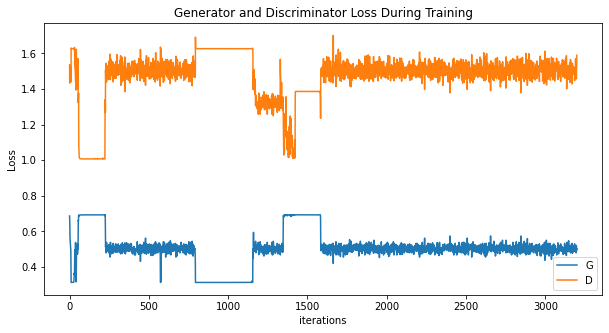

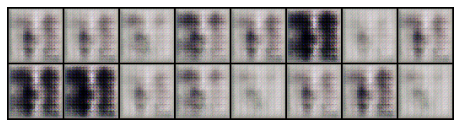

In [ ]:
discriminator = Discriminator()
generator = Generator()
if use_cuda and torch.cuda.is_available():
  discriminator.cuda()
  generator.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

generator.apply(weights_init)
discriminator.apply(weights_init)

step = 0
img_generated = []
G_losses = []
D_losses = []

train(generator, discriminator, lr=0.0002, num_epochs=100, batch_size = 128)